In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
dataset=pd.read_csv('tennis.csv')
print(dataset)

     Outlook Temperature Humidity    Wind PlayTennis
0      Sunny         Hot     High    Weak         No
1      Sunny         Hot     High  Strong         No
2   Overcast         Hot     High    Weak        Yes
3       Rain        Mild     High    Weak        Yes
4       Rain        Cool   Normal    Weak        Yes
5       Rain        Cool   Normal  Strong         No
6   Overcast        Cool   Normal  Strong        Yes
7      Sunny        Mild     High    Weak         No
8      Sunny        Cool   Normal    Weak        Yes
9       Rain        Mild   Normal    Weak        Yes
10     Sunny        Mild   Normal  Strong        Yes
11  Overcast        Mild     High  Strong        Yes
12  Overcast         Hot   Normal    Weak        Yes
13      Rain        Mild     High  Strong         No


In [11]:
import math
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [12]:
def entropy(series):
    probs = series.value_counts(normalize=True)
    return -(probs * np.log2(probs)).sum()

In [13]:
def info_gain(df, split_attr, target_col):
    base_entropy = entropy(df[target_col])
    vals = df[split_attr].unique()
    weighted_entropy = 0.0
    for v in vals:
        subset = df[df[split_attr] == v]
        weighted_entropy += (len(subset)/len(df)) * entropy(subset[target_col])
    return base_entropy - weighted_entropy


In [29]:
def id3(df, target_col, features=None, parent_class=None):
    if features is None:
        features = [c for c in df.columns if c != target_col]
    # If all targets same → return
    if len(df[target_col].unique()) == 1:
        return df[target_col].iloc[0]
    # If dataset empty → return parent class
    if df.empty:
        return parent_class
    # If no more features → return majority
    if not features:
        return df[target_col].mode()[0]
    parent_class = df[target_col].mode()[0]
    # Select best feature
    gains = {f: info_gain(df, f, target_col) for f in features}
    best_feature = max(gains, key=gains.get)
    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]
    for val in df[best_feature].unique():
        subset = df[df[best_feature] == val]
        subtree = id3(subset, target_col, remaining_features, parent_class)
        tree[best_feature][val] = subtree
    return tree


In [30]:
def predict_one(sample, tree, default=None):
    if not isinstance(tree, dict):
        return tree
    root = next(iter(tree))
    if root not in sample:
        return default
    val = sample[root]
    subtree = tree[root].get(val)
    if subtree is None:
        return default
    if isinstance(subtree, dict):
        return predict_one(sample, subtree, default)
    else:
        return subtree
def predict_df(df, tree, default=None):
    return df.apply(lambda row: predict_one(row, tree, default), axis=1)

In [23]:
def print_tree(tree, indent=''):
    if not isinstance(tree, dict):
        print(indent + "->", tree)
        return
    root = next(iter(tree))
    for val, subtree in tree[root].items():
        print(f"{indent}{root} = {val}:")
        print_tree(subtree, indent + "    ")

In [24]:
df=pd.DataFrame(dataset)

In [25]:
tree=id3(df,'PlayTennis')

In [26]:
print("===== ID3 Decision Tree (Text) =====")
print_tree(tree)

===== ID3 Decision Tree (Text) =====
Outlook = Sunny:
    Humidity = High:
        -> No
    Humidity = Normal:
        -> Yes
Outlook = Overcast:
    -> Yes
Outlook = Rain:
    Wind = Weak:
        -> Yes
    Wind = Strong:
        -> No


In [27]:
predictions = predict_df(df.drop(columns=['PlayTennis']), tree, default='Yes')
accuracy = (predictions == df['PlayTennis']).mean()
print("\nAccuracy (ID3):", accuracy)


Accuracy (ID3): 1.0


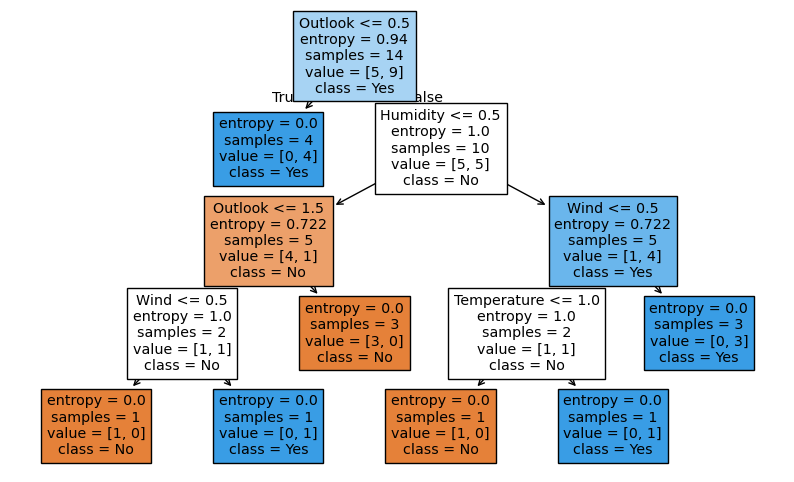

In [28]:
le = LabelEncoder()
df_enc = df.apply(le.fit_transform)
X = df_enc.drop(columns=['PlayTennis'])
y = df_enc['PlayTennis']
clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
clf.fit(X, y)
plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=X.columns, class_names=['No','Yes'], filled=True)
plt.show()